In [164]:
import torch as th 
import numpy as np 
import random 
import cv2
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms
import os
from sklearn.metrics import accuracy_score
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic = True

In [165]:
def replace_with_binary(tensor):
    # Проверяем размер входного тензора (n, 2)
    if tensor.size(-1) != 2:
        raise ValueError("Входной тензор должен иметь размер (n, 2)")

    # Создаем маски для максимального и минимального элементов в каждой паре
    max_elements, _ = th.max(tensor, dim=1)
    min_elements, _ = th.min(tensor, dim=1)

    # Создаем бинарный тензор, заменяя максимальный элемент на 1, минимальный на 0
    binary_tensor = th.where(tensor == max_elements.unsqueeze(1), th.tensor(1), 
                                th.where(tensor == min_elements.unsqueeze(1), th.tensor(0), tensor))

    return binary_tensor

In [166]:
class StegNN(th.nn.Module):
    def __init__(self):
        super(StegNN, self).__init__()
        self.conv1 = th.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=1) # 3x512x512 -> 8x512x512
        self.act_conv1 = th.nn.ReLU()
        self.pool1 = th.nn.MaxPool2d(kernel_size=5, padding=2, stride=4) # -> 8x128x128

        self.conv2 = th.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2, stride=1) # -> 16x128x128
        self.act_conv2 = th.nn.ReLU()
        self.pool2 = th.nn.MaxPool2d(kernel_size=5, padding=2, stride=4) # -> 16x32x32
        
        self.conv3 = th.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, padding=2, stride=1) # -> 64x32x32
        self.act_conv3 = th.nn.ReLU()
        self.pool3 = th.nn.MaxPool2d(kernel_size=5, padding=2, stride=4) # -> 64x8x8 

        self.fc1 = th.nn.Linear(8*8*64, 2048)
        self.act_lin1 = th.nn.Tanh()

        self.fc2 = th.nn.Linear(2048, 1024)
        self.act_lin2 = th.nn.Tanh()

        self.fc3 = th.nn.Linear(1024, 512)
        self.act_lin3 = th.nn.Tanh()

        self.fc4 = th.nn.Linear(512, 128)
        self.act_lin4 = th.nn.Tanh()

        self.fc5 = th.nn.Linear(128, 32)
        self.act_lin5 = th.nn.Tanh()

        self.fc6 = th.nn.Linear(32, 2) # 0 - ORIG 1 - ENCODE
        #self.act_lin6 = th.nn.Softmax()
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.act_conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act_conv2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act_conv3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act_lin1(x)

        x = self.fc2(x)
        x = self.act_lin2(x)

        x = self.fc3(x)
        x = self.act_lin3(x)

        x = self.fc4(x)
        x = self.act_lin4(x)

        x = self.fc5(x)
        x = self.act_lin5(x)

        x = self.fc6(x)
        #x = self.act_lin6(x)

        return x 
    
    def get_parameters(self):
        for par in self.parameters():
            print(par)




In [167]:
def train(net, X_train, y_train, X_test, y_test, batch_size=16, epoch_size=10, device='cpu'):
    net = net.to(device)
    loss = th.nn.CrossEntropyLoss()
    optimizer = th.optim.Adam(net.parameters(), lr=1.0e-3)
    
    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    print(f'MODEL: {net} \n DEVICE: {device} \n BATCH_SIZE: {batch_size} \n EPOCH_SIZE: {epoch_size}') 

    for epoch in range(epoch_size):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)  # forward pass 

            loss_value = loss(preds, y_batch)
            loss_value.backward()  # back propagation 
            optimizer.step() # step optimizer
             
            X_batch

        net.eval() # перевода модели в режим оценки

        y_preds = net.forward(X_test)
        loss_test = loss(y_preds, y_test).data
        test_loss_history.append(loss_test) #.to(device)) можно loss.item()
        y_preds = replace_with_binary(y_preds).data
        accuracy_test = accuracy_score(y_test, y_preds)

        print(f'Epoch: {epoch} || Accuracy: {accuracy_test} || Loss: {loss_test}')


    return test_accuracy_history, test_loss_history


In [168]:
def train_train(net, X_train, y_train, batch_size=16, epoch_size=10, device='cpu'):
    net = net.to(device)
    loss = th.nn.CrossEntropyLoss()
    optimizer = th.optim.Adam(net.parameters(), lr=1.0e-3)
    

    print(f'MODEL: {net} \n DEVICE: {device} \n BATCH_SIZE: {batch_size} \n EPOCH_SIZE: {epoch_size}') 

    for epoch in range(epoch_size):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)  # forward pass 

            loss_value = loss(preds, y_batch)

            loss_value.backward()  # back propagation 
            optimizer.step() # step optimizer
            
            X_batch

        net.eval() # перевода модели в режим оценки

        y_preds = net.forward(X_train)
        loss_test = loss(y_preds, y_train).data

        accuracy_test = accuracy_score(y_train, replace_with_binary(y_preds).data)
    
        
        print(f'Epoch: {epoch} || Accuracy: {accuracy_test} || Loss: {loss_test}')


    return 

In [169]:
def extraction_images(path_images):
    '''
    Загрузка датасета из директории
    Cжатие до указанного размера и представление в виде тензора(нормированного с MO = 0, D = 1) 
    return: th.Tensor [len(datasets), 3, 512, 512]
    '''
    transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor(), transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])
    dataset = datasets.ImageFolder(path_images, transform=transform)
    dataloader = th.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    data_iter = iter(dataloader)
    images, labels = data_iter.__next__() # shape -> [len(datasets), 3, 512, 512]

    return images

(684, 1024, 3)


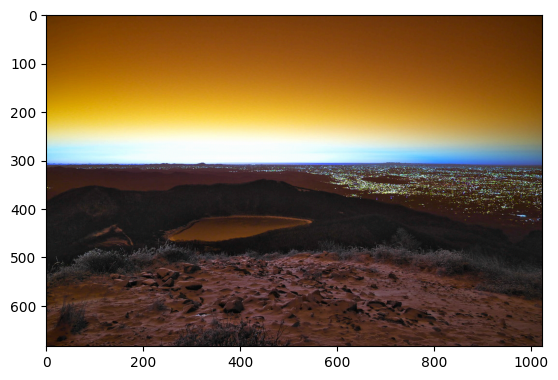

In [170]:
image = cv2.imread('./test_lsb/data/4120.png')
# #img = preprocess_image('./test_lsb/data/647.png')
# img.shape
# img = th.FloatTensor(img)
print(image.shape)
plt.imshow(image)

In [171]:
def download_dataset(path_orig: str, path_lsb: str):
    """
    return X, y
    X - тензор, куда помещены все изображения
    y - тензор размерность [n, 2], в котором 1 на первом месте соответсвует изображение со скрытой информацией,
    а 1 на втором месте соответсвует обычному изображению 
    n - общая длина датасета 
    изображения следуют в случайном порядке 
    """
    images_lsb = extraction_images(path_lsb)
    images_orig = extraction_images(path_orig)

    X = th.cat((images_lsb, images_orig), dim=0)

    y_lsb = th.zeros(images_lsb.shape[0], 2)
    y_lsb[:, 0] = 1

    y_orig = th.zeros(images_orig.shape[0], 2)
    y_orig[:, 1] = 1

    y = th.cat((y_lsb, y_orig), dim=0)

    permuted_indices = th.randperm(y.size(0))
    y = y[permuted_indices]
    X = X[permuted_indices]
    permuted_indices2 = th.randperm(y.size(0))
    y = y[permuted_indices2]
    X = X[permuted_indices2]
    permuted_indices3 = th.randperm(y.size(0))
    y = y[permuted_indices3]
    X = X[permuted_indices3]
    print(f" Размерность X: {X.shape} \n Размерность y: {y.shape} \n Изображений со скрытой информацией: {images_lsb.shape[0]} \n Обычных изображений: {images_orig.shape[0]}")

    return X, y

In [253]:
X_test, y_test = download_dataset('./test_lsb', './test_orig')


 Размерность X: torch.Size([609, 3, 512, 512]) 
 Размерность y: torch.Size([609, 2]) 
 Изображений со скрытой информацией: 280 
 Обычных изображений: 329


In [268]:
import os
import shutil
import random
import numpy as np

def shuffle_images_and_targets(folder_path_steg, folder_path_orig, target_folder_path):
    '''
    Функцию принимает путь к двум папкам(обычные изображения и со скрытой информацией)
    Затем перемешивает изображения и сохраняет в новую папку и возвращает соотсветсвующую target функцию 
    folder_path_steg - путь к изображениям со скрытой информацией 
    folder_path_orig - путь к обычным изображениям 
    target_folder_path - путь к новой папке, куда сохраняется результат 
    return: тензор закодированных данных размера (n, 2)// 1 на первом месте соответствует изображению со скрытой информацией 
    1 на втором месте соответствует обычному изображению 
    '''
    images_folder_steg = [os.path.join(folder_path_steg, f) for f in os.listdir(folder_path_steg) if os.path.isfile(os.path.join(folder_path_steg, f))]
    images_folder_orig = [os.path.join(folder_path_orig, f) for f in os.listdir(folder_path_orig) if os.path.isfile(os.path.join(folder_path_orig, f))]

    shuffled_targets = np.concatenate((np.ones(len(images_folder_steg)), np.zeros(len(images_folder_orig))))
    shuffled_images = images_folder_steg + images_folder_orig
    order = np.random.permutation(len(shuffled_targets))
    shuffled_images = list(map(shuffled_images.__getitem__, order.tolist()))
    shuffled_targets = shuffled_targets[order]

    
    # сохраняем всё в номую папку 
    idx = 1
    for image_path in shuffled_images:
        file_name = f"shuffled_data_{idx}.jpg"
        shutil.copy(image_path, os.path.join(target_folder_path, file_name))
        idx+=1
        

    # преобразуем массив в тензор нужного размера для обучения
    tensor_target = th.zeros(len(shuffled_targets), 2)
    for i in range(len(shuffled_targets)):
        if shuffled_targets[i] == 1:
            tensor_target[i][0] = 1
        else:
            tensor_target[i][1] = 1

    return tensor_target

In [270]:
y_train = shuffle_images_and_targets('./test_lsb/data', './test_orig/data', './test')

In [271]:
y_train

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

Batch Processing

In [194]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import os
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, folder_path, targets, image_size=(512, 512)):
        self.folder_path = folder_path
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])
        self.image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.targets = targets

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        target = self.targets[idx]
        return image, target

In [283]:
def train_model_with_batch_processing(image_folder, targets, X_test, y_test, target_image_size=(512, 512), batch_size=24, num_epochs=10):
    # Создаем экземпляр CustomImageDataset
    custom_dataset = CustomImageDataset(folder_path=image_folder, targets=targets, image_size=target_image_size)

    # Создаем DataLoader для обучения
    train_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)

    # Определение модели нейронной сети (вам нужно заменить это на свою собственную модель)
    model = StegNN()

    # Определение функции потерь и оптимизатора
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Обучение модели с использованием DataLoader и пакетного обучения
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Обнуляем градиенты
            optimizer.zero_grad()
            model.train()

            # Прямой проход
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Обратное распространение
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        model.eval()
        y_preds = model.forward(X_test)
        loss_test = loss(y_preds, y_test).data

        accuracy_test = accuracy_score(y_test, replace_with_binary(y_preds).data)
    
        
        print(f'Epoch: {epoch} || Accuracy: {accuracy_test} || Loss: {loss_test}')